import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
## Adult income classification
---
* Dataset information

> The data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

## Task
---
> ##### Predict whether income exceeds $50K/yr based on census data


### Importing libraries

In [136]:
!python3 -m pip install numpy pandas scikit-learn seaborn

In [137]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [138]:
def load_data():
    return pd.read_csv('data/income_data.csv')

In [139]:
income_data = load_data()

In [140]:
income_data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


##### Shape of the data

In [141]:
instances = income_data.shape[0]
attributes = income_data.shape[1]

In [142]:
print(f"Number of rows in data => {instances},\nand number of columns in data => {attributes}")

Number of rows in data => 32561,
and number of columns in data => 15


In [143]:
from sklearn.model_selection import train_test_split

In [144]:
X_train,X_test,y_train,y_test = train_test_split(income_data.iloc[:,:14],income_data['income'],test_size=0.2)

In [145]:
income_data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

In [146]:
income_data.income.unique()

array(['<=50K', '>50K'], dtype=object)

<h1 style="text-align:center">Data Preprocessing</h1>

### Mapping <=50k to Class 0, and >50k to Class 1

In [147]:
def classEncoder(value):
    if value == '<=50K':
        return 0
    elif value == '>50K':
        return 1

In [148]:
y_train = y_train.apply(classEncoder)
y_test = y_test.apply(classEncoder)

In [149]:
y_test.head()

11305    0
2614     1
2481     1
11202    0
15637    1
Name: income, dtype: int64

In [150]:
y_train.unique()

array([0, 1])

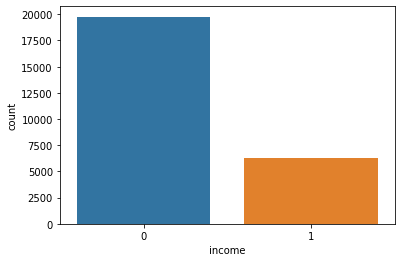

In [151]:
sns.countplot(y_train)

### We see that the classes are imbalanced. We will take care of this in the later part of the notebook.
* How does imbalanced classes affect the predictions?
> If we don't fix this problem of imbalanced dataset, then the model will be highly biased towards the dominating class.

In [152]:
X_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
27454,32,Private,137875,Some-college,10,Divorced,Sales,Unmarried,White,Female,0,0,30,United-States
19896,54,Self-emp-not-inc,124865,Some-college,10,Divorced,Sales,Not-in-family,White,Female,0,0,35,United-States
17156,36,Private,398931,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,United-States
19854,41,Private,372682,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States
28924,28,Private,198197,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,55,United-States


In [153]:
#X_train.workclass[23724]

In [154]:
X_train.isna().any()

age               False
workclass         False
fnlwgt            False
education         False
education.num     False
marital.status    False
occupation        False
relationship      False
race              False
sex               False
capital.gain      False
capital.loss      False
hours.per.week    False
native.country    False
dtype: bool

### We see that there are no NULL/NaN values in the dataset.
> Looks straightforward right? No, don't be fooled by this. We see that there are many values that have '?' in place of NaN or Null values. This is why data exploration is very important. The data collection group decided to put a '?' in place of missing values. It's our job to handle this problem. 

In [155]:
for attribute in X_train.columns[:-1]:
    print("Attribute = {}, Unique values = {}".format(attribute,X_train[attribute].nunique()))

Attribute = age, Unique values = 73
Attribute = workclass, Unique values = 9
Attribute = fnlwgt, Unique values = 18356
Attribute = education, Unique values = 16
Attribute = education.num, Unique values = 16
Attribute = marital.status, Unique values = 7
Attribute = occupation, Unique values = 15
Attribute = relationship, Unique values = 6
Attribute = race, Unique values = 5
Attribute = sex, Unique values = 2
Attribute = capital.gain, Unique values = 116
Attribute = capital.loss, Unique values = 89
Attribute = hours.per.week, Unique values = 91



### Let's look at each feature one by one and transform it to get rid of missing values

#### A list of attributes to keep track of attributes that needs to be transformed

In [156]:
transform_attributes_train = []
transform_attributes_test = []

---
1. <h3><strong style="color:red">Age</strong> attribute</h3>

In [157]:
age_series = X_train.age

In [158]:
age_list = list(age_series)

In [159]:
'?' in age_list

False

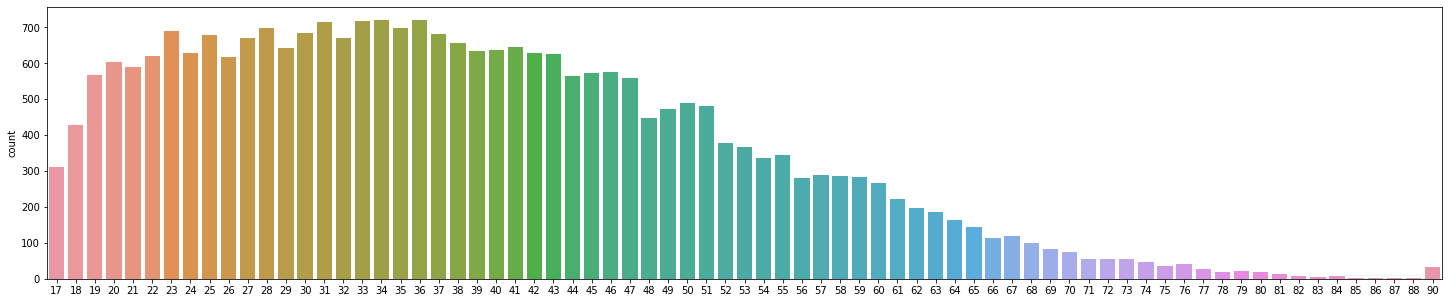

In [160]:
plt.figure(figsize=(25,5))
sns.countplot(age_list)

> The age attribute does not have any '?' or missing values

---
2. <h3><strong style="color:red">WorkClass</strong> attribute</h3>

In [161]:
workclass_list = list(X_train.workclass)

In [162]:
'?' in workclass_list

True

> workclass attribute has some values as '?'

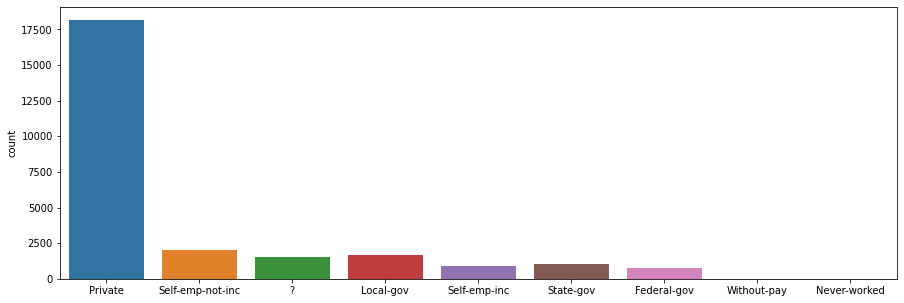

In [163]:
plt.figure(figsize=(15,5))
sns.countplot(workclass_list)

> We find that there are a small number of values with '?'

* Now what we will do is replace all the '?' values with NaN so that we can drop or transform them later

### To speed up this process of identifying '?' in an attribute let's create a function

In [164]:
def detect_missing_values_train(attribute):
    if '?' in list(X_train[attribute]):
        transform_attributes_train.append(attribute)
def detect_missing_values_test(attribute):
    if '?' in list(X_test[attribute]):
        transform_attributes_test.append(attribute)

In [165]:
for attribute in X_train.columns:
    detect_missing_values_train(attribute)
for attribute in X_test.columns:
    detect_missing_values_test(attribute)

In [166]:
print(transform_attributes_train)
print(transform_attributes_test)

['workclass', 'occupation', 'native.country']
['workclass', 'occupation', 'native.country']


### We see that there are 3 attributes with '?' as missing values


In [167]:
for attribute in transform_attributes_train:
    X_train[attribute] = X_train[attribute].replace('?', np.NaN)
    X_test[attribute] = X_test[attribute].replace('?', np.NaN)

In [168]:
X_train.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
27454,32,Private,137875,Some-college,10,Divorced,Sales,Unmarried,White,Female,0,0,30,United-States
19896,54,Self-emp-not-inc,124865,Some-college,10,Divorced,Sales,Not-in-family,White,Female,0,0,35,United-States
17156,36,Private,398931,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,United-States
19854,41,Private,372682,Some-college,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States
28924,28,Private,198197,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,55,United-States


### A much faster approach
> If you're sure about your data that it only has some other string to represent missing values and feel like you can skip exploring all the attributes, the below piece of code does the same exact thing

In [169]:
X_train = X_train.replace('?',np.NaN)
X_test = X_test.replace('?',np.NaN)

In [170]:
X_test.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
11305,59,Local-gov,238431,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,0,38,United-States
2614,36,Private,262688,Some-college,10,Married-civ-spouse,Sales,Husband,Black,Male,7688,0,50,United-States
2481,45,Private,178319,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,7688,0,50,United-States
11202,40,Private,173858,7th-8th,4,Married-civ-spouse,Other-service,Husband,Asian-Pac-Islander,Male,0,0,42,Cambodia
15637,52,Private,74024,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,45,United-States


### Now we are ready to deal with missing values however we like.

> Check how many are there

In [171]:
X_train.isna().sum()

age                  0
workclass         1503
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1509
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     452
dtype: int64

> We see that there are 3 attributes with NaN values(obviousoly). There corresponding percentages are :

In [172]:
print("WorkClass missing value proportion = {}% of whole data".format(round(1453/X_train.shape[0],2)*100))
print("Occupation missing value proportion = {}% of whole data".format(round(1458/X_train.shape[0],2)*100))
print("Native COuntry missing value proportion = {}% of whole data".format(round(467/X_train.shape[0],2)*100))

WorkClass missing value proportion = 6.0% of whole data
Occupation missing value proportion = 6.0% of whole data
Native COuntry missing value proportion = 2.0% of whole data


In [173]:
X_test.isna().sum()

age                 0
workclass         333
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation        334
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country    131
dtype: int64

In [174]:
print("WorkClass missing value proportion = {}% of whole data".format(round(383/X_test.shape[0],2)*100))
print("Occupation missing value proportion = {}% of whole data".format(round(385/X_test.shape[0],2)*100))
print("Native COuntry missing value proportion = {}% of whole data".format(round(116/X_test.shape[0],2)*100))

WorkClass missing value proportion = 6.0% of whole data
Occupation missing value proportion = 6.0% of whole data
Native COuntry missing value proportion = 2.0% of whole data


### How to deal with missing values?
> There are majorly 3 ways to deal with missing values
1. Drop the row with missing value
2. Drop the column with missing value
3. Impute missing values with some value (mean,median or mode)

### Let's check these 3 attributes to check if we can impute them
---

#### Attribute 1 - workclass

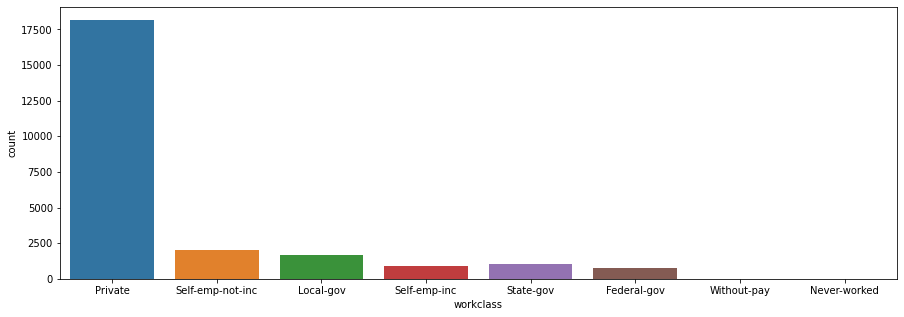

In [175]:
plt.figure(figsize=(15,5))
sns.countplot(X_train.workclass)

### As wee see from this simple plot that Private is the dominating type of workclass, we can impute the missing values in workclass with mode i.e Private

In [176]:
X_train['workclass'] = X_train['workclass'].fillna('Private')
X_test['workclass'] = X_test['workclass'].fillna('Private')

In [177]:
X_test.workclass.isna().sum()

0

#### Attribute 2 - Occupation

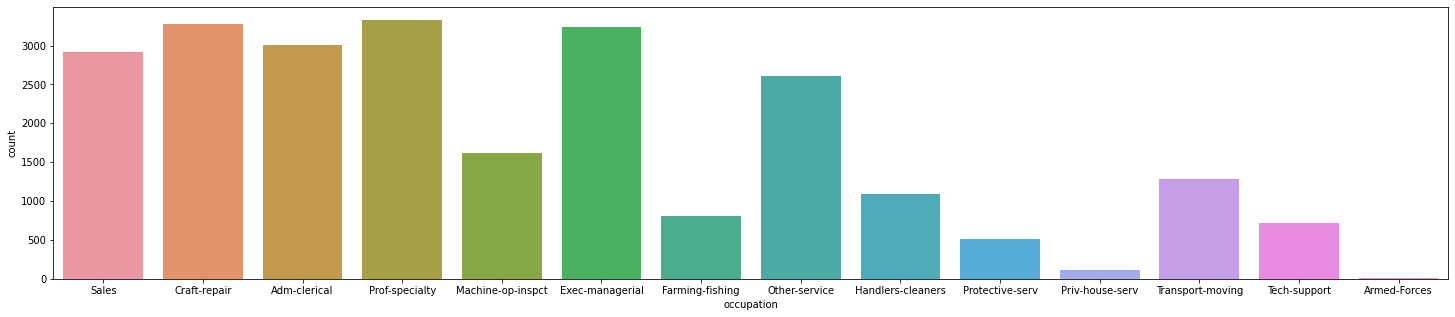

In [178]:
plt.figure(figsize=(25,5))
sns.countplot(X_train.occupation)

In [179]:
X_train['occupation'].mode()[0]

'Prof-specialty'

### We can apply same strategy as before
> I encourage you to play with more methods of handling missing values like dropping the record(row) with missing values. Check and compare results.

In [180]:
X_train['occupation'] = X_train['occupation'].fillna(income_data.occupation.mode()[0])
X_test['occupation'] = X_test['occupation'].fillna(income_data.occupation.mode()[0])

In [181]:
X_test.occupation.isna().sum()

0

#### Attribute 3 - Native Country

In [182]:
X_train['native.country'].isna().sum()

452

In [183]:
X_train['native.country'].value_counts()

United-States                 23331
Mexico                          512
Philippines                     164
Germany                         110
Canada                           98
Puerto-Rico                      89
India                            83
El-Salvador                      81
Cuba                             76
England                          73
Jamaica                          70
South                            67
Italy                            63
Dominican-Republic               57
China                            56
Guatemala                        51
Vietnam                          51
Poland                           47
Japan                            47
Columbia                         46
Taiwan                           43
Haiti                            38
Iran                             34
Portugal                         32
France                           27
Nicaragua                        27
Greece                           24
Ecuador                     

> Since almost 89% of the records have native country as United States, we will be replaces missing values with United-States

In [184]:
X_train['native.country'] = X_train['native.country'].fillna(X_train['native.country'].mode()[0])
X_test['native.country'] = X_test['native.country'].fillna(X_test['native.country'].mode()[0])

In [185]:
X_test['native.country'].isna().sum()

0

### Now we don't have any missing or NaN values in our data.

In [186]:
X_train.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64

In [187]:
X_test.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64

In [188]:
X_train.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64

In [189]:
X_test.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
dtype: int64

<h1 style="text-align:center">Feature Engineering</h1>

> Let's first get the statistics of the dataset

In [190]:
X_train.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,26048.000000,2.604800e+04,26048.000000,26048.000000,26048.000000,26048.000000
mean,38.604576,1.903976e+05,10.082770,1101.051367,84.818451,40.423257
std,13.657166,1.058611e+05,2.575489,7496.945669,397.480600,12.369037
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.182472e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.791615e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.381850e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.455435e+06,16.000000,99999.000000,4356.000000,99.000000


#### Looking at the above output, it seems like our datasets requires feature scaling.
> ! It generally depends on the type of training algorithm you would use. For example, tree based models don't require feature scaling. But it's a good precautionary discipline.

### Before rescaling the data, let's convert non numeric attributes to numeric attributes

In [191]:
X_train.select_dtypes(include='object')

,workclass,education,marital.status,occupation,relationship,race,sex,native.country
27454,Private,Some-college,Divorced,Sales,Unmarried,White,Female,United-States
19896,Self-emp-not-inc,Some-college,Divorced,Sales,Not-in-family,White,Female,United-States
17156,Private,HS-grad,Divorced,Craft-repair,Not-in-family,White,Male,United-States
19854,Private,Some-college,Married-civ-spouse,Adm-clerical,Wife,White,Female,United-States
28924,Private,Bachelors,Never-married,Prof-specialty,Not-in-family,White,Male,United-States
...,...,...,...,...,...,...,...,...
4669,Private,Bachelors,Never-married,Exec-managerial,Not-in-family,Black,Male,United-States
26855,Federal-gov,Some-college,Married-civ-spouse,Adm-clerical,Husband,White,Male,United-States
28830,Private,HS-grad,Never-married,Prof-specialty,Unmarried,Black,Female,United-States
6852,Private,Masters,Married-civ-spouse,Sales,Husband,White,Male,United-States


### There are 8 columns that are categorical. We will be encoding them in some way so that they can be used as numeric values

> We will first create seperate lists for Nominal and Ordinal attributes

In [192]:
nominal_attributes = ['workclass','marital.status','occupation','relationship','race','sex','native.country']
ordinal_attributes = ['education']

* Since 'education' is an ordinal attribute i.e. it has an order. For example, a person with 7th-8th grade is on a lower level of education as compared to a Bachelor

* We can encode it with OrdinalEncoder class of sklearn but since we have an attribute named 'education.num', it represents the encodings of the education attribute.

* We will now drop the education attribute

In [193]:
X_train.drop(['education'],axis=1,inplace=True)

In [194]:
X_test.drop(['education'],axis=1,inplace=True)

In [195]:
X_train.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
27454,32,Private,137875,10,Divorced,Sales,Unmarried,White,Female,0,0,30,United-States
19896,54,Self-emp-not-inc,124865,10,Divorced,Sales,Not-in-family,White,Female,0,0,35,United-States
17156,36,Private,398931,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,40,United-States
19854,41,Private,372682,10,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States
28924,28,Private,198197,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,55,United-States


#### Handling nominal attributes

* We can encode nominal attributes with variety of ways. Some of them are:
    1. One Hot Encoding 
    2. Target Encoding
    3. Hashing 


> We will be using Target Encoding and replacing categories with mean of targets for that particular category

In [196]:
def target_encoder(attribute,target):
    X_train_copy = X_train.copy()
    X_train_copy['income'] = target
    encoding_map = {}
    unique_values = X_train_copy[attribute].unique()
    for value in unique_values:
        encoding_map[value] = round(X_train_copy[X_train_copy[attribute] == value]['income'].mean(),2)
        
    return encoding_map
    

> We will skip target encoding for race and sex attributes because they will be One Hot Encoded because they have low cardinality

In [197]:
for attribute in nominal_attributes:
    if attribute not in ['race','sex']:
        encoding = target_encoder(attribute,y_train)
        X_train[attribute] = X_train[attribute].map(encoding)
        X_test[attribute] = X_test[attribute].map(encoding)

In [198]:
X_train.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
27454,32,0.21,137875,10,0.10,0.27,0.06,White,Female,0,0,30,0.25
19896,54,0.29,124865,10,0.10,0.27,0.10,White,Female,0,0,35,0.25
17156,36,0.21,398931,9,0.10,0.23,0.10,White,Male,0,0,40,0.25
19854,41,0.21,372682,10,0.45,0.13,0.47,White,Female,0,0,40,0.25
28924,28,0.21,198197,13,0.05,0.34,0.10,White,Male,0,0,55,0.25


In [199]:
X_test.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
11305,59,0.29,238431,9,0.10,0.13,0.06,White,Female,0,0,38,0.25
2614,36,0.21,262688,10,0.45,0.27,0.45,Black,Male,7688,0,50,0.25
2481,45,0.21,178319,16,0.45,0.34,0.45,White,Male,7688,0,50,0.25
11202,40,0.21,173858,4,0.45,0.04,0.45,Asian-Pac-Islander,Male,0,0,42,0.40
15637,52,0.21,74024,14,0.45,0.34,0.45,White,Male,0,0,45,0.25


## Now all of our attributes with high cardinality are encoded as numericals.
## We will now handle low cardinality attributes i.e. race & sex
> We will be using OneHotEncoder class of sklearn

In [200]:
from sklearn.preprocessing import OneHotEncoder

In [201]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

In [202]:
X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)

In [203]:
def oneHotEncode(X_train,X_test,attribute):
    train_encodings = one_hot_encoder.fit_transform(X_train[[attribute]]).toarray()
    test_encodings = one_hot_encoder.transform(X_test[[attribute]]).toarray()
    train_encodings_df = pd.DataFrame(train_encodings,columns=X_train[attribute].unique())
    test_encodings_df = pd.DataFrame(test_encodings,columns=X_train[attribute].unique())
    X_train = X_train.join(train_encodings_df)
    X_test = X_test.join(test_encodings_df)
    X_train.drop(attribute,axis=1,inplace=True)
    X_test.drop(attribute,axis=1,inplace=True)
    return X_train,X_test
    
    
    

In [204]:
for i in ['race','sex']:
    X_train,X_test = oneHotEncode(X_train,X_test,i)

### IMPORTANT
---
> Since after one hot encoding sex attribute, we get two attributes Male and Female. We can drop one of them for obvious reasons

In [205]:
X_train.drop('Male',inplace=True,axis=1)
X_test.drop('Male',inplace=True,axis=1)

---
## Now all of our attributes are numericals.
> Now we will be performing feature scaling to bring them to the same scale

In [206]:
from sklearn.preprocessing import StandardScaler

In [207]:
scaler = StandardScaler()

In [208]:
scaled_X_train = scaler.fit_transform(X_train)

X_train = pd.DataFrame(scaled_X_train,columns=X_train.columns)

In [209]:
scaled_X_test = scaler.transform(X_test)
X_test = pd.DataFrame(scaled_X_test,columns=X_test.columns)

In [210]:
X_test.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,capital.gain,capital.loss,hours.per.week,native.country,White,Black,Other,Amer-Indian-Eskimo,Asian-Pac-Islander,Female
0,1.493415,0.702995,0.453749,-0.420421,-0.745829,-0.829924,-0.919938,-0.146869,-0.213394,-0.195917,0.117823,-0.096434,-0.181758,-0.324026,-0.092925,0.411434,1.424867
1,-0.190715,-0.428094,0.682893,-0.032138,1.077646,0.210747,1.073559,0.878634,-0.213394,0.774266,0.117823,-0.096434,-0.181758,3.086170,-0.092925,-2.430525,-0.701820
2,0.468292,-0.428094,-0.114100,2.297561,1.077646,0.731083,1.073559,0.878634,-0.213394,0.774266,0.117823,-0.096434,-0.181758,-0.324026,-0.092925,0.411434,-0.701820
3,0.102177,-0.428094,-0.156241,-2.361837,1.077646,-1.498927,1.073559,-0.146869,-0.213394,0.127477,3.687595,-0.096434,5.501828,-0.324026,-0.092925,-2.430525,-0.701820
4,0.980854,-0.428094,-1.099326,1.520994,1.077646,0.731083,1.073559,-0.146869,-0.213394,0.370023,0.117823,-0.096434,-0.181758,-0.324026,-0.092925,0.411434,-0.701820


In [211]:
X_train.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,capital.gain,capital.loss,hours.per.week,native.country,White,Black,Other,Amer-Indian-Eskimo,Asian-Pac-Islander,Female
0,-0.483607,-0.428094,-0.496156,-0.032138,-0.745829,0.210747,-0.919938,-0.146869,-0.213394,-0.842706,0.117823,-0.096434,-0.181758,-0.324026,-0.092925,0.411434,1.424867
1,1.127300,0.702995,-0.619055,-0.032138,-0.745829,0.210747,-0.715477,-0.146869,-0.213394,-0.438463,0.117823,-0.096434,-0.181758,-0.324026,-0.092925,0.411434,1.424867
2,-0.190715,-0.428094,1.969916,-0.420421,-0.745829,-0.086588,-0.715477,-0.146869,-0.213394,-0.034220,0.117823,-0.096434,-0.181758,-0.324026,-0.092925,0.411434,-0.701820
3,0.175400,-0.428094,1.721955,-0.032138,1.077646,-0.829924,1.175789,-0.146869,-0.213394,-0.034220,0.117823,-0.096434,-0.181758,-0.324026,-0.092925,0.411434,1.424867
4,-0.776499,-0.428094,0.073678,1.132711,-1.006326,0.731083,-0.715477,-0.146869,-0.213394,1.178509,0.117823,-0.096434,-0.181758,-0.324026,-0.092925,0.411434,-0.701820


### Let's now see correlation of attributes

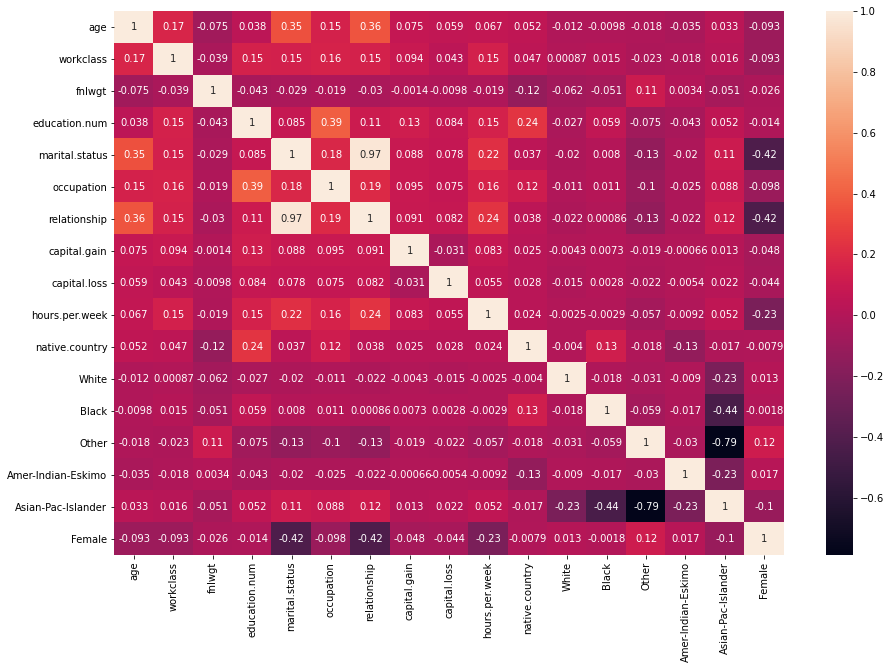

In [212]:
plt.figure(figsize=(15,10))
sns.heatmap(X_train.corr(),annot=True)

### Let's create a baseline model.
> We will be using Logistic Regression

In [213]:
from sklearn.linear_model import LogisticRegression

In [214]:
from sklearn.model_selection import cross_val_score

In [215]:
logistic_regressor = LogisticRegression()

In [216]:
scores=cross_val_score(logistic_regressor,X_train,y_train,cv=10)

In [217]:
print("Accuracy: %0.2f" % (scores.mean()))

Accuracy: 0.85


> We are getting mean accuracy of 85% on validation data but as data is imbalanced hence we need to check other metrics like Precision ans Recall.
Let's see how it performs on test data.

In [218]:
lgreg = logistic_regressor.fit(X_train,y_train)

In [221]:
y_preds = lgreg.predict(X_test)

In [222]:
from sklearn.metrics import precision_score,recall_score

In [223]:
precision = precision_score(y_test,y_preds)

In [224]:
precision

0.7288

In [225]:
recall = recall_score(y_test,y_preds)

In [226]:
recall

0.5836002562459962